In [14]:
# ========================================
# Library
# ========================================
import math
import random
import pickle
import joblib
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb
import datetime

In [15]:
road_df = pd.read_csv('C:/Users/brain/Desktop/nexcoeast_v2/train/road.csv')
search_spec_df = pd.read_csv('C:/Users/brain/Desktop/nexcoeast_v2/train/search_data.csv')
search_unspec_df = pd.read_csv('C:/Users/brain/Desktop/nexcoeast_v2/train/search_unspec_data.csv')
train_df = pd.read_csv('C:/Users/brain/Desktop/nexcoeast_v2/train/train.csv')

In [16]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day

    return df

In [17]:
def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])

    train_df = expand_datetime(train_df)
    # search_spec_df = expand_datetime(search_spec_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    return train_df

In [18]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

train['section'] = train['start_code'].astype(str)+'_'+train['end_code'].astype(str)

cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'dayofweek']
num_cols = ['year', 'month', 'day', 'hour', 'search_1h', 'search_unspec_1d', 'KP', 'start_KP', 'end_KP', 'limit_speed',
            'OCC', 'allCars', 'speed', 'start_pref_code', 'end_pref_code', 'start_lat', 'end_lat', 'start_lng', 'end_lng',
            'start_degree', 'end_degree']
feature_cols = cat_cols + num_cols

In [19]:
# ========================================
# カテゴリ変数の処理
# ========================================
le_dict = {}
for c in tqdm(cat_cols):
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    le_dict[c] = le

with open("features/le_dict.pkl", "wb") as f:
    pickle.dump(le_dict, f)

100%|██████████| 6/6 [00:00<00:00, 17.09it/s]


In [20]:
# ========================================
# training module
# ========================================
def f1(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)
    score = f1_score(y_true, y_pred)
    return 'f1', score, True

def train_lgbm(X,
               y,
               cv,
               model_path = [],
               params: dict=None,
               verbose: int=100
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]


        clf = lgb.LGBMClassifier(**params)

        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                early_stopping_rounds=100,
                verbose=verbose,
                eval_metric=f1,
                )

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = f1_score(y_valid, (pred_i > 0.5).astype(int))
        print(f" - fold{i + 1} - {score:.4f}")

    score = f1_score(y, (oof_pred > 0.5).astype(int))

    print("=" * 50)
    print(f"FINISH: CV Score: {score:.4f}")
    return score, oof_pred, models

In [21]:
# ========================================
# parameters
# ========================================
max_depth = 7
params = {
    "objective": "binary",
    "max_depth": max_depth,
    'num_leaves' : int(0.7 * 2 ** max_depth),#240
    "n_estimators": 100000,
    "learning_rate": 0.02,
    "importance_type": "gain",
    "random_state": 42,
    "verbose": -1,
}
# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols].values
y = train[TARGET].values

print('train shape:', train.shape)
# ========================================
# training
# ========================================
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list)

train shape: (910080, 30)
[100]	valid_0's binary_logloss: 0.00200499	valid_0's f1: 0.953608
 - fold1 - 0.9555
[100]	valid_0's binary_logloss: 0.0016482	valid_0's f1: 0.966646
[200]	valid_0's binary_logloss: 0.000818284	valid_0's f1: 0.971357
 - fold2 - 0.9720
[100]	valid_0's binary_logloss: 0.00193371	valid_0's f1: 0.955077
[200]	valid_0's binary_logloss: 0.00109521	valid_0's f1: 0.958537
[300]	valid_0's binary_logloss: 0.000990263	valid_0's f1: 0.961023
[400]	valid_0's binary_logloss: 0.000982898	valid_0's f1: 0.962241
 - fold3 - 0.9623
[100]	valid_0's binary_logloss: 0.00155747	valid_0's f1: 0.975236
 - fold4 - 0.9764
[100]	valid_0's binary_logloss: 0.00204288	valid_0's f1: 0.950725
[200]	valid_0's binary_logloss: 0.00124612	valid_0's f1: 0.954128
[300]	valid_0's binary_logloss: 0.00114551	valid_0's f1: 0.957422
[400]	valid_0's binary_logloss: 0.00113185	valid_0's f1: 0.956221
 - fold5 - 0.9580
FINISH: CV Score: 0.9649


In [22]:
for i, m in enumerate(models):
   with open(f'../model/lgb_fold{i}.pickle', mode="wb") as f:
      pickle.dump(m, f)

print(classification_report(train['is_congestion'], oof_pred))
print(train['is_congestion'].sum(), oof_pred.sum())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    906031
           1       0.95      0.98      0.96      4049

    accuracy                           1.00    910080
   macro avg       0.97      0.99      0.98    910080
weighted avg       1.00      1.00      1.00    910080

4049 4184.0


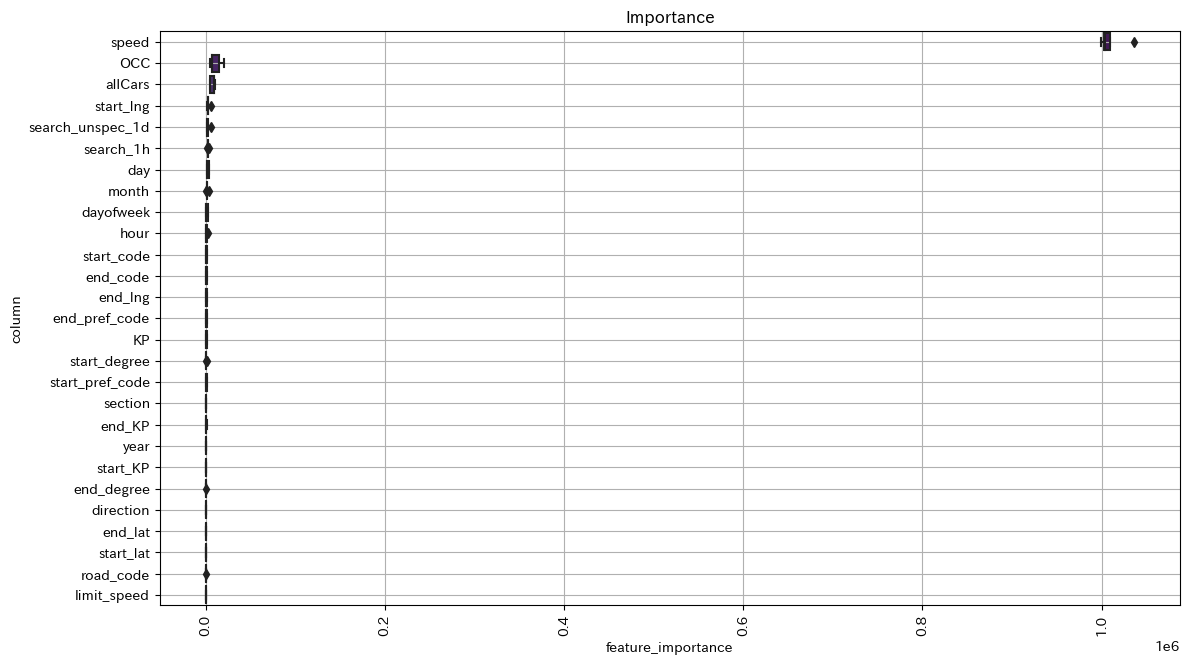

In [23]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train[feature_cols])